In [1]:
import sys, os
sys.path = list(set(sys.path + ['./src']))
import numpy as np
from scipy.sparse import lil_matrix, csr_matrix
import matplotlib.pyplot as plt

from chap_redux.wrapper import CHAP, ModelType, ConfigInit, SaveInit

RSEED = 12345
np.random.seed(RSEED)

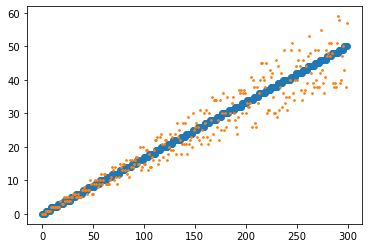

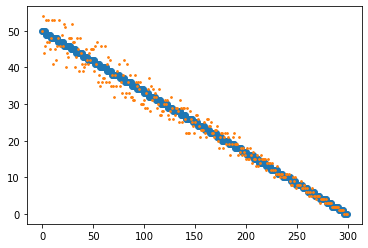

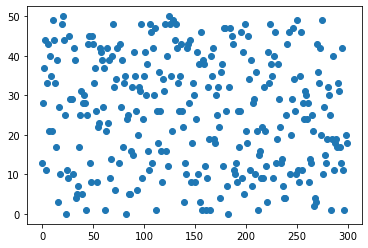

In [18]:
points = 300
steps = 50
x = np.array(range(points))

a1 = np.round(x/points*steps)
noise = 25
a2 = [np.round((np.random.random()-0.5)*noise*v/steps) + v for v in a1]
plt.scatter(range(points), a1)
plt.scatter(range(points), a2, s=3)
plt.show()

b1 = steps - np.round(x/points*steps)
noise = 15
b2 = [np.round((np.random.random()-0.5)*noise*v/steps) + v for v in b1]
plt.scatter(range(points), b1)
plt.scatter(range(points), b2, s=3)
plt.show()

c1 = [np.round(np.random.random()*steps) for _ in x]
plt.scatter(range(points), c1)
plt.show()

# pairs a and b correlate between themselves and negatively correlate with each other
# c is just noise

In [19]:
labels = [a1, a2, b1, b2, c1]
nsamples, nlabels = 3000, 25

# induce label sparseness
label_indicies = list(range(nlabels))
np.random.shuffle(label_indicies)
label_indicies = label_indicies[:len(labels)]

# induce sample sparseness
sample_indicies = list(range(nsamples))
np.random.shuffle(sample_indicies)
sample_indicies = sample_indicies[:points]

low_val = 1
X = np.ones((nsamples, nlabels)) # random sampling will otherwise produce completely empty samples if not 1s
for srci, i in enumerate(sample_indicies):
    for srcj, j in enumerate(label_indicies):
        X[i, j] = labels[srcj][srci]

In [24]:
mname = 'synthetic_test'
os.system('rm -r ./out/synthetic_test') # each model needs a unique name
# the vocab dictionary is not used for caclulations
vocab = dict([(n, label_indicies[i]) for i, n in enumerate(['a1', 'a2', 'b1', 'b2', 'c1'])])
# vocab['for_non_zero'] = nlabels
for i in range(nlabels):
    if i not in label_indicies:
        vocab[f'empty{i}'] = i
model = CHAP(ConfigInit(mname, ModelType.SOAP, vocab, num_components=5, num_epochs=3, num_jobs=4, random_state=RSEED))
model.fit(csr_matrix(X))
# can also use lil_matrix
# model.fit(lil_matrix(X))

	>> The following arguments are applied:
		1. Number of features: 25
		2. Number of mixture components: 5
		3. Number of features per component for sparseness: 10
		4. Prior of component mean `mu`: 0.0001
		5. Prior of component correlation `sigma`: 0.0001
		6. Prior of component feature distribution `phi`: 0.0001
		7. A hyper-parameter for omega parameter (gamma): 2.0
		8. Additional hyper-parameter for omega parameter (kappa): 3.0
		9. Prior of supplementary features: 0.04
		10. The parameter controlling component feature distribution: 1.0
		11. Optimization algorithm used? Newton-CG
		12. Perplexity tolerance: 0.001
		13. Maximum number of random samplings: 3
		14. Collapse estimation to CTM model? False
		15. Employ external component features? False
		16. Forgetting rate to control how quickly old information is forgotten: 0.9
		17. Delay factor down weights early iterations: 1.0
		18. Subsampling inputs: 0.1
		19. Number of examples to use in each iteration: 50
		20. Number of in

	>> Training by SOAP model...
	   1)- Epoch count (1/3)...
	       --> Computing E-step: 100.00%...
	       --> Computing M-step...
		## Epoch 1 took 8.221 seconds...
		  --> New cost: 1.1091; Old cost: inf
		  --> Storing the SOAP phi to: synthetic_test_exp_phi.npz
		  --> Storing the SOAP sigma to: synthetic_test_sigma.npz
		  --> Storing the SOAP mu to: synthetic_test_mu.npz
		  --> Storing the SOAP model to: synthetic_test.pkl
	   2)- Epoch count (2/3)...
	       --> Computing E-step: 100.00%...
	       --> Computing M-step...
		## Epoch 2 took 2.186 seconds...
		  --> New cost: 0.9341; Old cost: 1.1091
		  --> Storing the SOAP phi to: synthetic_test_exp_phi.npz
		  --> Storing the SOAP sigma to: synthetic_test_sigma.npz
		  --> Storing the SOAP mu to: synthetic_test_mu.npz
		  --> Storing the SOAP model to: synthetic_test.pkl
	   3)- Epoch count (3/3)...
	       --> Computing E-step: 100.00%...
	       --> Computing M-step...
		## Epoch 3 took 1.967 seconds...
		  --> New cost: 1.

'/home/tony/workspace/python/grad/PathPred/chap/out/synthetic_test'

In [25]:
npz = np.load(f'./out/{mname}/model/{mname}_exp_phi_final.npz')
group_coefs = npz[npz.files[0]]
group_coefs.shape # bags x original labels

(5, 25)

In [36]:
# can load previous models like so
loaded_model = CHAP(SaveInit(mname))
loaded_model._name

'synthetic_test'

In [38]:
# relabel inuts as "topics" or groups like so
tx = model.transform(csr_matrix(X))
tx.shape

	       --> Computing E-step: 100.00%...


(3000, 5)